In [1]:
import re
from pathlib import Path
from pprint import pp

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    PredictionErrorDisplay,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from P03_run_diff_sigma.T00_lib.classes_ml import MyUtil
from P03_run_diff_sigma.T00_lib.utils import check_jupyter

In [2]:
SAVE_DATA = False
MAKE_ONE_HOT = False

In [3]:
if check_jupyter():
    BASE_DIR = Path.cwd()  # Current directory of the running file
    DATA_DIR = BASE_DIR.parent / "T02_combine_features"
    CURRENT_DIR = BASE_DIR
else:
    BASE_DIR = Path.cwd()  # Base directory of the project
    DATA_DIR = BASE_DIR / "src/P3_run_diff_sigma/T02_combine_features"
    CURRENT_DIR = Path(__file__).resolve().parent

dt = MyUtil.get_dt()
print(f"Current Directory: {CURRENT_DIR}")
print(f"Current Date and Time: {dt}")

# Load data
df = pd.read_excel(DATA_DIR / "S02_data_combined_loc.xlsx")
print(df.shape)
df

Code is running in a Jupyter environment.
Current Directory: c:\Users\admin\Coding\research\weld-ml\src\P03_run_diff_sigma\T31_tabpfn
Current Date and Time: 2026-01-23_06-52
(378, 180)


,sample_no,R,W,D,position,location,fz_location,"dwell_Fz__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""",dwell_Fz__mean_change,"dwell_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0",...,"weld_Fz__fft_coefficient__attr_""angle""__coeff_26","weld_Fz__fft_coefficient__attr_""angle""__coeff_86","weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.2","weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2",weld_Fz__ratio_beyond_r_sigma__r_2.5,weld_Fz__binned_entropy__max_bins_10,weld_Fz__kurtosis,stress_value_5052,stress_value_6061,stress_value_center
0,1,1400,60,10,0.153846,1,1.244326,-0.015598,-0.000466,-0.000466,...,-59.307464,-126.394608,0.000592,0.000077,0.011999,1.996898,0.031761,28.0,51.0,12.0
1,2,1400,60,15,0.153846,1,1.203367,-0.001207,-0.000060,-0.000060,...,-67.104324,-83.441169,0.001515,0.000074,0.026536,1.433742,2.139541,14.0,-21.0,17.0
2,3,1400,60,20,0.153846,1,1.444542,-0.004830,-0.000198,-0.000198,...,-73.946166,-100.226178,0.002915,0.000764,0.046766,1.651073,1.957977,10.0,35.0,12.0
3,4,1400,70,10,0.153846,1,1.601667,-0.012681,-0.000459,-0.000459,...,-109.557287,-92.120362,-0.002131,-0.000669,0.032843,1.331185,3.615244,10.0,-10.0,20.0
4,5,1400,70,15,0.153846,1,1.095031,-0.028589,-0.000819,-0.000819,...,142.508379,101.664911,0.005496,0.000705,0.017408,1.739714,-0.003368,6.0,41.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,50,1600,70,15,0.846154,7,1.905742,-0.025181,-0.000835,-0.000835,...,100.417769,70.734310,-0.000276,0.000027,0.012383,2.073254,-0.284814,4.0,-23.0,2.0
374,51,1600,70,20,0.846154,7,1.669120,-0.019329,-0.000656,-0.000656,...,77.002325,105.356086,0.002244,0.000891,0.000090,2.110911,-0.807980,0.0,-1.0,2.0
375,52,1600,80,10,0.846154,7,1.671576,-0.034536,-0.000915,-0.000915,...,-114.510109,160.581335,0.002110,0.000548,0.011999,1.947229,-0.492903,-2.0,-41.0,5.0
376,53,1600,80,15,0.846154,7,1.686495,-0.060666,-0.001356,-0.001356,...,49.909992,-131.625465,0.003661,0.001454,0.042150,1.607697,1.674617,10.0,-90.0,1.0


In [4]:
colsY = [c for c in df.columns if re.search(r"stress_value", c)]
print(colsY)
colsX = [c for c in df.columns if c not in colsY]
print(colsX)

['stress_value_5052', 'stress_value_6061', 'stress_value_center']
['sample_no', 'R', 'W', 'D', 'position', 'location', 'fz_location', 'dwell_Fz__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"', 'dwell_Fz__mean_change', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6', 'dwell_Fz__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0', 'dwell_Fz__partial_autocorrelation__lag_3', 'dwell_Fz__approximate_entropy__m_2__r_0.9', 'dwell_Fz__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"', 'dwell_Fz__fft_coefficient__attr_"real"__coeff_4', 'dwell_Fz__partial_autocorrelation__lag_7', 'dwell_Fz__symmetry_looking__r_0.05', 'dwell_Fz__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.8', 'dwell_Fz__fft_coefficient__attr_"angle"__coeff_88', 'dwell_Fz__fft_coefficient__attr_"angle"__coeff_4', 'dw

In [5]:
dfY = df[colsY]
dfX_all = df[colsX]

print(dfX_all.shape)
print(dfY.shape)

(378, 177)
(378, 3)


In [6]:
if MAKE_ONE_HOT:
    dft1 = pd.get_dummies(
        dfX_all, columns=["location", "R", "W", "D"], drop_first=False, dtype=int
    )
    dfX = dft1.drop(columns=["sample_no"])
else:
    dfX = dfX_all.drop(columns=["sample_no", "location"])
dfX

,R,W,D,position,fz_location,"dwell_Fz__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""",dwell_Fz__mean_change,"dwell_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0","dwell_Fz__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.6","dwell_Fz__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""",...,"weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.0","weld_Fz__fft_coefficient__attr_""real""__coeff_9","weld_Fz__fft_coefficient__attr_""real""__coeff_6","weld_Fz__fft_coefficient__attr_""angle""__coeff_26","weld_Fz__fft_coefficient__attr_""angle""__coeff_86","weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.2","weld_Fz__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.2",weld_Fz__ratio_beyond_r_sigma__r_2.5,weld_Fz__binned_entropy__max_bins_10,weld_Fz__kurtosis
0,1400,60,10,0.153846,1.244326,-0.015598,-0.000466,-0.000466,0.054540,0.003409,...,0.001825,58.401601,359.260272,-59.307464,-126.394608,0.000592,0.000077,0.011999,1.996898,0.031761
1,1400,60,15,0.153846,1.203367,-0.001207,-0.000060,-0.000060,0.066685,0.002961,...,0.002662,188.462577,388.213274,-67.104324,-83.441169,0.001515,0.000074,0.026536,1.433742,2.139541
2,1400,60,20,0.153846,1.444542,-0.004830,-0.000198,-0.000198,0.054354,0.004525,...,0.002434,79.638692,403.636989,-73.946166,-100.226178,0.002915,0.000764,0.046766,1.651073,1.957977
3,1400,70,10,0.153846,1.601667,-0.012681,-0.000459,-0.000459,0.058211,0.004067,...,-0.001110,-8.572183,365.722847,-109.557287,-92.120362,-0.002131,-0.000669,0.032843,1.331185,3.615244
4,1400,70,15,0.153846,1.095031,-0.028589,-0.000819,-0.000819,0.055285,0.000968,...,0.002638,34.610547,247.173607,142.508379,101.664911,0.005496,0.000705,0.017408,1.739714,-0.003368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,1600,70,15,0.846154,1.905742,-0.025181,-0.000835,-0.000835,0.069095,0.003179,...,0.000366,50.879103,174.902227,100.417769,70.734310,-0.000276,0.000027,0.012383,2.073254,-0.284814
374,1600,70,20,0.846154,1.669120,-0.019329,-0.000656,-0.000656,0.070212,0.003283,...,0.000177,62.884040,204.961686,77.002325,105.356086,0.002244,0.000891,0.000090,2.110911,-0.807980
375,1600,80,10,0.846154,1.671576,-0.034536,-0.000915,-0.000915,0.072483,0.002971,...,0.001576,19.546750,222.308684,-114.510109,160.581335,0.002110,0.000548,0.011999,1.947229,-0.492903
376,1600,80,15,0.846154,1.686495,-0.060666,-0.001356,-0.001356,0.094026,0.005970,...,0.002470,-26.434232,212.964893,49.909992,-131.625465,0.003661,0.001454,0.042150,1.607697,1.674617


In [7]:
# Extract features and targets
_X = dfX.values
_Y = dfY.values

print(_X.shape)
print(_Y.shape)

(378, 175)
(378, 3)


In [8]:
_X_train, _X_test, _Y_train, _Y_test = train_test_split(
    _X, _Y, test_size=0.3, random_state=1
)
print(_X_train.shape)
print(_X_test.shape)
print(_Y_train.shape)
print(_Y_test.shape)

(264, 175)
(114, 175)
(264, 3)
(114, 3)


In [9]:
scX = StandardScaler()
X_train = scX.fit_transform(_X_train)
X_test = scX.transform(_X_test)

scY = StandardScaler()
Y_train = scY.fit_transform(_Y_train)
Y_test = scY.transform(_Y_test)

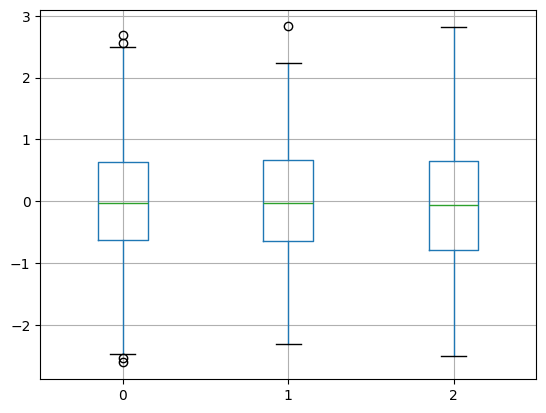

In [10]:
pd.DataFrame(Y_train).boxplot()
plt.show()

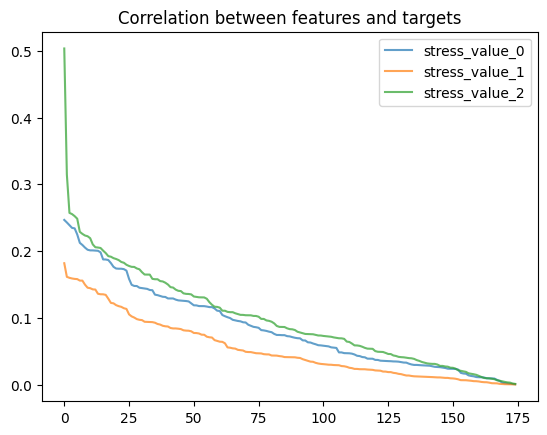

In [25]:
import numpy as np
# Correlation between features and targets
corr_matrix_0 = pd.DataFrame(X_train).corrwith(pd.DataFrame(Y_train).iloc[:, 0]).abs().sort_values(ascending=False)
corr_matrix_1 = pd.DataFrame(X_train).corrwith(pd.DataFrame(Y_train).iloc[:, 1]).abs().sort_values(ascending=False)
corr_matrix_2 = pd.DataFrame(X_train).corrwith(pd.DataFrame(Y_train).iloc[:, 2]).abs().sort_values(ascending=False)

# Plot correlation
xp = np.arange(len(corr_matrix_0))
fig, ax = plt.subplots()
ax.plot(xp, corr_matrix_0, label="stress_value_0")
ax.plot(xp, corr_matrix_1, label="stress_value_1")
ax.plot(xp, corr_matrix_2, label="stress_value_2")
plt.title("Correlation between features and targets")
plt.legend()
plt.show()


# Find max correlation index
max_corr_idx_0 = corr_matrix_0.idxmax()
max_corr_idx_1 = corr_matrix_1.idxmax()


In [27]:
corr_matrix_0 = pd.DataFrame(X_train).corrwith(pd.DataFrame(Y_train).iloc[:, 0]).abs()
corr_matrix_1 = pd.DataFrame(X_train).corrwith(pd.DataFrame(Y_train).iloc[:, 1]).abs()
corr_matrix_2 = pd.DataFrame(X_train).corrwith(pd.DataFrame(Y_train).iloc[:, 2]).abs()

# Max
max_corr_idx_0 = corr_matrix_0.idxmax()
max_corr_idx_1 = corr_matrix_1.idxmax()
max_corr_idx_2 = corr_matrix_2.idxmax()
print("Max correlation index for stress_value_0:", max_corr_idx_0)
print("Max correlation index for stress_value_1:", max_corr_idx_1)
print("Max correlation index for stress_value_2:", max_corr_idx_2)

print(colsX[max_corr_idx_0])
print(colsX[max_corr_idx_1])
print(colsX[max_corr_idx_2])

Max correlation index for stress_value_0: 80
Max correlation index for stress_value_1: 37
Max correlation index for stress_value_2: 3
weld_Fz__fft_coefficient__attr_"imag"__coeff_32
dwell_Fz__fft_coefficient__attr_"angle"__coeff_35
D


In [12]:
from sklearn.multioutput import MultiOutputRegressor
from tabpfn import TabPFNRegressor
from tabpfn.constants import ModelVersion
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Initialize the regressor
# reg = MultiOutputRegressor(
#     TabPFNRegressor()
# )
# Uses TabPFN-2.5 weights, trained on synthetic data only.
# To use TabPFN v2:
# regressor = TabPFNRegressor.create_default_for_version(ModelVersion.V2)
reg = MultiOutputRegressor(GradientBoostingRegressor())

In [13]:
reg.fit(X_train, Y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor())

In [14]:
Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)

print(Y_train_pred.shape)
print(Y_test_pred.shape)

(264, 3)
(114, 3)


In [15]:
def eval_perf(y_true, y_pred):
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    return mse, mape, r2


def print_perf(data):
    for k, v in data.items():
        print(k, ":", v)


data_arr = []
for i in range(0, _Y.shape[1]):
    mse_train, mape_train, r2_train = eval_perf(
        y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
    )
    mse_test, mape_test, r2_test = eval_perf(
        y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
    )

    data = {
        "Y": f"Y-{i + 1}",
        "MSE Train": mse_train,
        "MSE Test": mse_test,
        "MAPE Train": mape_train,
        "MAPE Test": mape_test,
        "R2 Train": r2_train,
        "R2 Test": r2_test,
    }
    # print_perf(data)

    data_arr.append(data)

mse_train, mape_train, r2_train = eval_perf(y_true=Y_train, y_pred=Y_train_pred)
mse_test, mape_test, r2_test = eval_perf(y_true=Y_test, y_pred=Y_test_pred)
print_perf(data)

data = {
    "Y": "Y-All",
    "MSE Train": mse_train,
    "MSE Test": mse_test,
    "MAPE Train": mape_train,
    "MAPE Test": mape_test,
    "R2 Train": r2_train,
    "R2 Test": r2_test,
}
data_arr.append(data)
# print_perf(data)

df_eval = pd.DataFrame.from_dict(data_arr)
display(df_eval)

if SAVE_DATA:
    filename = f"eval_{dt}.xlsx"
    df_eval.to_excel(filename, index=False)

Y : Y-3
MSE Train : 0.08394152237833404
MSE Test : 0.5070597063074092
MAPE Train : 0.6457179648875342
MAPE Test : 1.1828648625030411
R2 Train : 0.916058477621666
R2 Test : 0.40555191991867123


,Y,MSE Train,MSE Test,MAPE Train,MAPE Test,R2 Train,R2 Test
0,Y-1,0.133178,1.200739,1.162106,2.250641,0.866822,0.060704
1,Y-2,0.243148,1.021151,0.941815,3.339132,0.756852,-0.245269
2,Y-3,0.083942,0.507060,0.645718,1.182865,0.916058,0.405552
3,Y-All,0.153423,0.909650,0.916546,2.257546,0.846577,0.073662


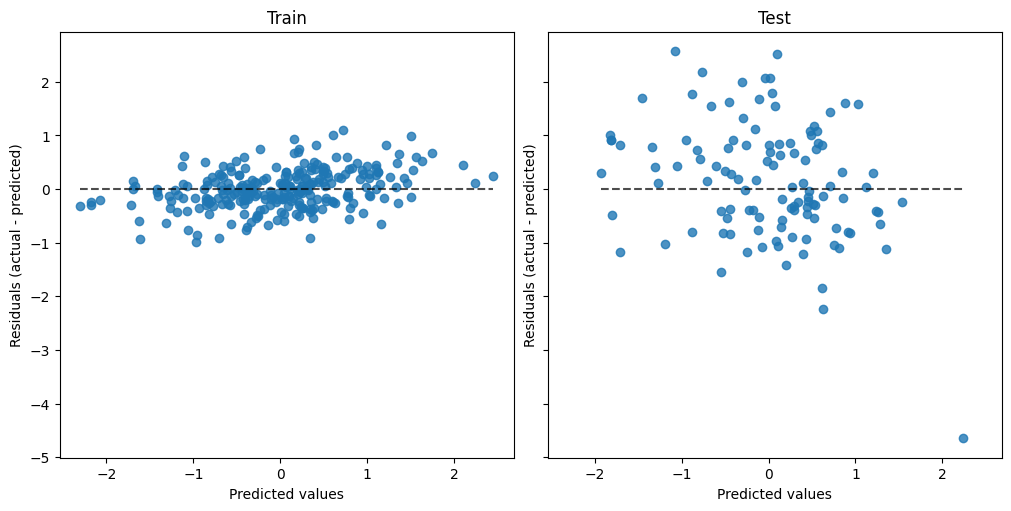

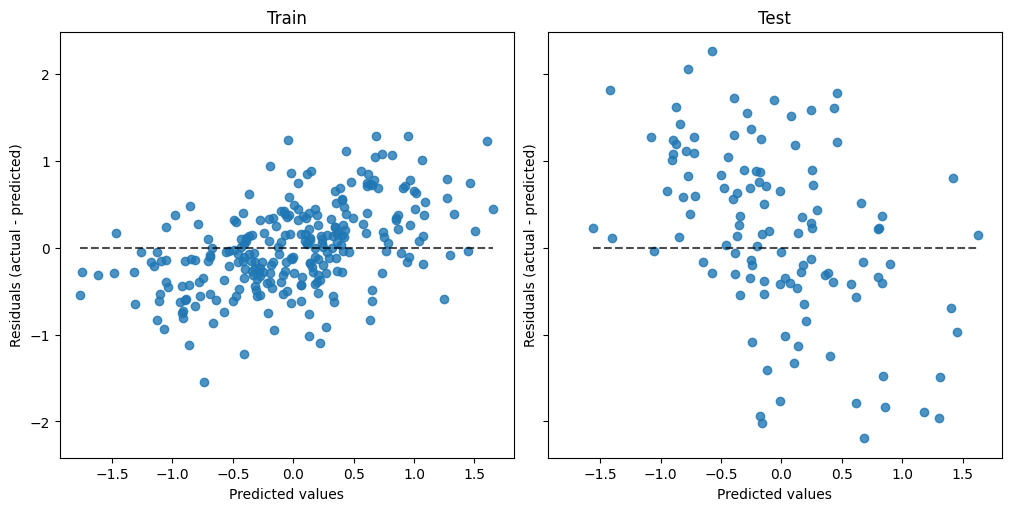

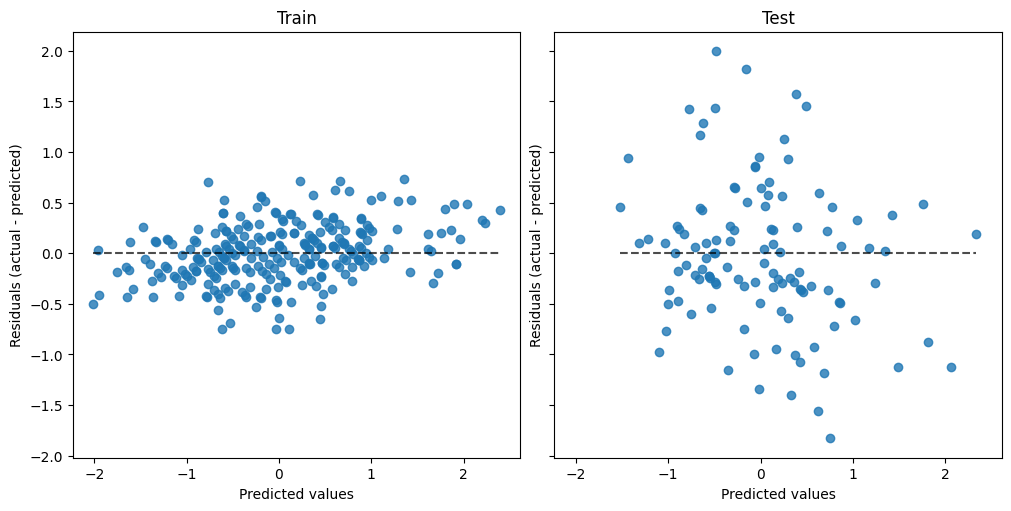

In [16]:
for i in range(0, _Y.shape[1]):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(10, 5),
        constrained_layout=True,
        sharex=True,
        sharey=True,
    )

    display_train = PredictionErrorDisplay(
        y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
    )
    display_train.plot(ax=axes[0])
    axes[0].set_title("Train")

    display_train = PredictionErrorDisplay(
        y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
    )
    display_train.plot(ax=axes[1])
    axes[1].set_title("Test")

    if SAVE_DATA:
        filename = f"res_plot_{dt}_{i}.png"
        fig.savefig(filename, dpi=300)

    plt.show()